8장 생성 신경망

In [ ]:
# 예제 8.1 잡음 제거 스택 오토 인코더(MNIST)

#셋업
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 데이터셋 준비
(x_train, _), (x_test, _) = mnist.load_data()   # 레이블은 사용하지 않음

# 데이터 정규화
x_train = x_train / 255.
x_test = x_test / 255.

In [ ]:
# 2차원 이미지를 1차원 벡터로 변환
x_train = x_train.reshape(x_train.shape[0], 28 * 28)
x_test = x_test.reshape(x_test.shape[0], 28 * 28)

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [ ]:
# 잡음 추가(평균 0/표준편차 0.5)/잡음 추가한 결과 조정(0 ~ 1)
noise = np.random.normal(loc=0, scale=0.5, size=x_train.shape)
x_train_noise = x_train + noise

noise = np.random.normal(loc=0, scale=0.5, size=x_test.shape)
x_test_noise = x_test + noise

x_train_noise = np.clip(x_train_noise, a_min=0, a_max=1)
x_test_noise = np.clip(x_test_noise, a_min=0, a_max=1)

In [ ]:
# 인코더 정의
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.dense1 = Dense(units=latent_dim * 2, activation='relu')
        self.dense2 = Dense(units=latent_dim, activation='relu')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [ ]:
# 디코더 정의
class Decoder(Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.dense1 = Dense(units=latent_dim * 2, activation='relu')
        self.dense2 = Dense(units=28 * 28, activation='sigmoid')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [ ]:
# 스택 오토 인코더 정의
class StackAutoEncoder(Model):
    def __init__(self, latent_dim):
        super(StackAutoEncoder, self).__init__()
        #self.loss = []
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        return x

# 모델 생성
model = StackAutoEncoder(latent_dim=32)

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

In [ ]:
# 모델 학습
history = model.fit(x_train_noise, x_train, batch_size=32, epochs=10,
                    verbose=0)

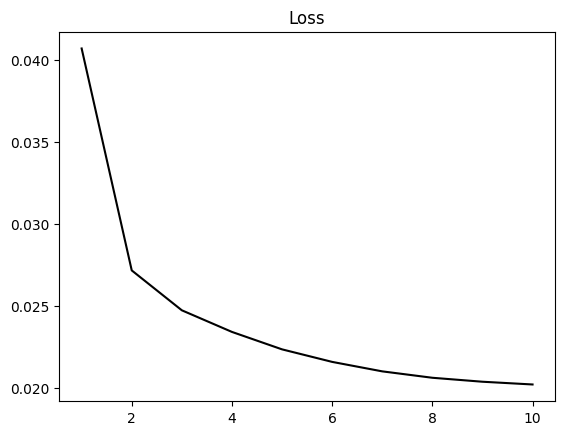

In [ ]:
# 학습 결과 시각화
plt.plot(range(1, len(history.history['loss']) + 1),
         history.history['loss'], color='black')
plt.title('Loss')

plt.show()

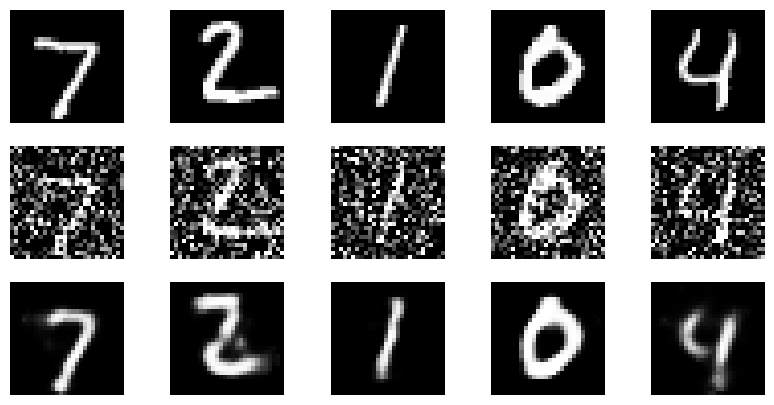

In [ ]:
# 원본 이미지/잡음 추가 이미지/재구성 이미지 시각화
plt.figure(figsize=(10, 5))

for i in range(5):

    # 원본 이미지
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # 잡음 추가 이미지
    ax = plt.subplot(3, 5, i + 1 + 5)
    plt.imshow(x_test_noise[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # 재구성 이미지
    ax = plt.subplot(3, 5, i + 1 + 10)
    plt.imshow(model(x_test)[i].numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
# 예제 8.2 VAE 변형 오토 인코더(MNIST)

#셋업
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Layer
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 데이터셋 준비
(x_train, _), (_, _) = mnist.load_data()   # 레이블/테스트 데이터는 사용하지 않음

# 데이터 정규화
x_train = x_train / 255.

# 2차원 영상을 3차원으로 변환
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

print(x_train.shape)

(60000, 28, 28, 1)


In [ ]:
# 인코더 정의
latent_dim = 2

inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, kernel_size=3, strides=2, padding='same',
           activation='relu')(inputs)
x = Conv2D(64, kernel_size=3, strides=2, padding='same',
           activation='relu')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
mu = Dense(latent_dim)(x)
log_var = Dense(latent_dim)(x)

encoder = Model(inputs, [mu, log_var])

In [ ]:
# 잠재 공간 샘플링 계층 정의
class Sampling(Layer):
    def call(self, mu, log_var):
        epsilon = tf.random.normal(tf.shape(log_var))
        return mu + tf.exp(0.5 * log_var) * epsilon

In [ ]:
# 디코더 정의
decoder_inputs = Input(shape=(latent_dim,))
x = Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same',
                    activation='relu')(x)
x = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same',
                    activation='relu')(x)
outputs = Conv2D(1, kernel_size=3, strides=1, padding='same',
                 activation='sigmoid')(x)

decoder = Model(decoder_inputs, outputs)

In [ ]:
# 변형 오토 인코더 정의
mu, log_var = encoder(inputs)
z = Sampling()(mu, log_var)
reconstruction = decoder(z)

# 모델 생성
model = Model(inputs, reconstruction)

In [ ]:
# 모델 컴파일
latent_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.exp(log_var)   # 잠재 손실
                                   - tf.square(mu), axis=-1)
latent_loss = tf.reduce_mean(latent_loss) / 784   # 픽셀 당 잠재 손실
model.add_loss(latent_loss)   # 손실 = 재구성 손실(출력, 정답) + 잠재 손실

model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# 모델 학습
history = model.fit(x_train, x_train, epochs=10, batch_size=32, verbose=0)

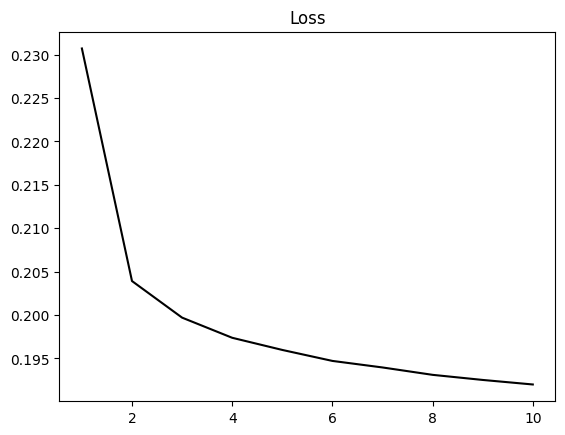

In [ ]:
# 학습 결과 시각화
plt.plot(range(1, len(history.history['loss']) + 1),
         history.history['loss'], color='black')
plt.title('Loss')

plt.show()

In [ ]:
# 이미지 생성
n = 100   # 이미지 수

generated_images = []
for i in range(n):
    latent_point = np.random.normal(size=(1, 2))   # 잠재 공간의 점
    decoded_image = decoder.predict(latent_point)
    image = decoded_image[0].reshape(28, 28)
    generated_images.append(image)

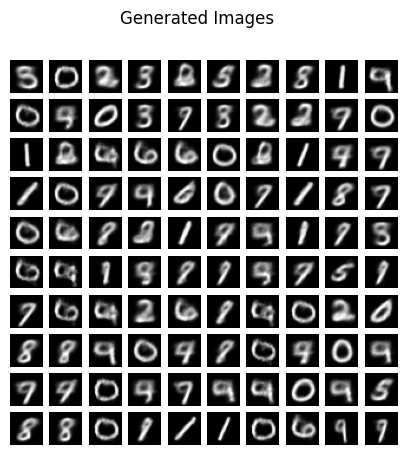

In [ ]:
# 생성 이미지 시각화
plt.figure(figsize=(5, 5))
plt.suptitle('Generated Images')

for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
# 예제 8.3 DCGAN(MNIST)

# 셋업
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display

# 데이터셋 준비
(x_train, _), (_, _) = mnist.load_data()   # 레이블/테스트 데이터는 사용하지않음

In [ ]:
# 데이터 정규화(-1 ~ !)
x_train = (x_train.astype(np.float32) - 127.5 ) / 127.5

# 2차원 이미지를 3차원으로 변환
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

print(x_train.shape)

(60000, 28, 28, 1)


In [ ]:
# 소규모 MNIST 데이터셋 생성
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(32)

x_train = x_train.take(200)   # 6,400개(200x32) 샘플

In [ ]:
# 생성자 정의
generator = Sequential([
    Dense(7 * 7 * 128, input_shape=(100, )),
    BatchNormalization(),
    ReLU(),
    Reshape((7, 7, 128)),

    Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2DTranspose(32, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2DTranspose(1, kernel_size=4, strides=1, padding='same',
                    activation='tanh')],
    name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (Batch  (None, 6272)              25088     
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        131136    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        25

In [ ]:
# 판별자 정의
discriminator = Sequential([
    Conv2D(32, kernel_size=4, strides=2, padding='same',
           input_shape=(28, 28, 1)),
    LeakyReLU(negative_slope=0.2),

    Conv2D(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.2),

    Conv2D(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.2),

    Flatten(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')],
    name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        544       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          32832     
                                                                 
 batch_normalization_3 (Bat  (None, 7, 7, 64)          256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         131200    
                                                     

In [ ]:
# 하이퍼파라미터 설정
batch_size = 32   # 배치 크기
latent_dim = 100   # 랜덤 벡터 차원
num_generate = 100   # 생성할 이미지 수
seed = tf.random.normal([num_generate, latent_dim])   # 생성자 학습 시작 입력

# 손실 함수 설정
bce_loss = tf.keras.losses.BinaryCrossentropy()

# 옵티마이저 설정
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:
# 학습 루프 함수 정의
@tf.function   # 함수를 그래프로 변환하여 속도 향상
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])   # 랜덤 벡터

    # 판별자 학습
    with tf.GradientTape() as tape:   # 자동 미분 수행
        real_output = discriminator(images, training=True)
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)

        real_loss = bce_loss(tf.ones_like(real_output), real_output)
        fake_loss = bce_loss(tf.zeros_like(fake_output), fake_output)
        d_loss = real_loss + fake_loss

    d_gradient = tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(
        zip(d_gradient, discriminator.trainable_variables))

    # 생성자 학습
    with tf.GradientTape() as tape:   # 자동 미분 수행
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)
        g_loss = bce_loss(tf.ones_like(fake_output), fake_output)

    g_gradient = tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(
        zip(g_gradient, generator.trainable_variables))

In [ ]:
# 이미지 생성/저장 함수 정의
def generate_save_images(model, epoch, inputs):
    prediction = model(inputs, training=False)
    min = tf.reduce_min(prediction)
    max = tf.reduce_max(prediction)
    prediction = (prediction - min) / (max - min)  # 픽셀 값(0 ~ 1)

    fig = plt.figure(figsize=(5, 5))
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    for i in range(prediction.shape[0]):
        plt.subplot(10, 10, i + 1)
        plt.imshow(prediction[i], cmap='gray')
        plt.axis('off')

    plt.savefig(f"image at epoch {epoch}.png")

    plt.show()

In [ ]:
# 학습 함수 정의
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # 에포크마다 이미지 생성
        display.clear_output(wait=True)
        print(f"Generated Images at Epoch {epoch + 1}")
        generate_save_images(generator, epoch + 1, seed)

Generated Images at Epoch 50


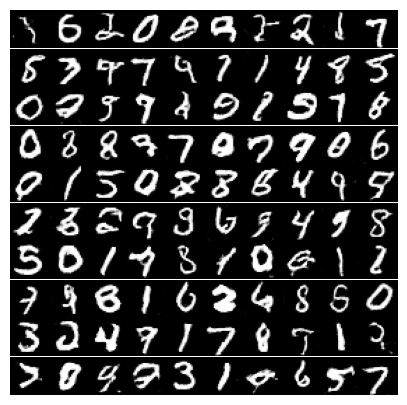

In [ ]:
# 학습(이미지 생성)
train(x_train, epochs=50)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 모델 저장
generator.save('/content/drive/MyDrive/small_mnist_gan.keras')

In [ ]:
# 모델 불러오기
generator = tf.keras.models.load_model(
    '/content/drive/MyDrive/small_mnist_gan.keras')

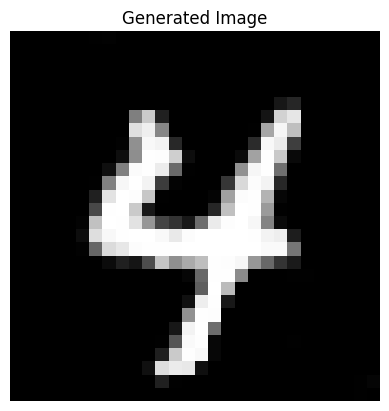

In [ ]:
# 생성 이미지 확인
tf.random.set_seed(3)

noise = tf.random.normal([1, 100])
generated_image = generator(noise)

plt.imshow(generated_image[0], cmap='gray')
plt.title('Generated Image')
plt.axis('off')

plt.show()

In [ ]:
# 예제 8.4 스타일 전이

# 셋업
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 콘텐츠 이미지/스타일 이미지 크기 확인
content_path = '/content/drive/MyDrive/Datasets/풍차.JPG'  # 파일 경로 지정
content_img = Image.open(content_path)   # 이미지 가져오기

style_path = tf.keras.utils.get_file(    # Wikimedia Commons에서 다운로드
    'Composition7.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/6/69'
    '/Wassily_Kandinsky_Composition_VII.jpg')
style_img = Image.open(style_path)

print(f"size of content image: {content_img.size}")   # 콘텐츠 이미지 크기 확인
print(f"size of style image: {style_img.size}")   # 스타일 이미지 크기 확인

size of content image: (1920, 1080)
size of style image: (1800, 1218)


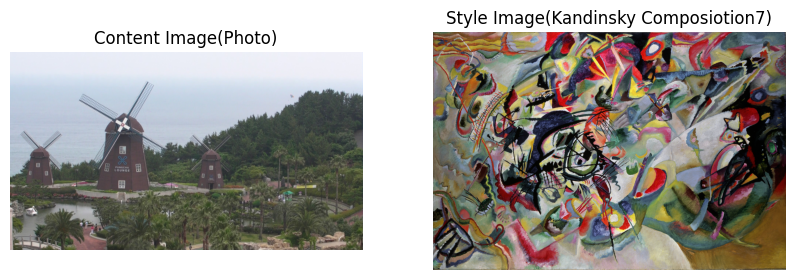

In [ ]:
# 콘텐츠 이미지/스타일 이미지 시각화
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(content_img)
plt.title('Content Image(Photo)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(style_img)
plt.title('Style Image(Kandinsky Composiotion7)')
plt.axis('off')

plt.show()

In [ ]:
# 콘텐츠 이미지/스타일 이미지/스타일 전이 이미지 준비
width, height = content_img.size
img_height = 160
img_width = int(width * img_height / height)   # 이미지의 가로x세로 비율 유지

# 콘텐츠 이미지
content_image = tf.keras.utils.load_img(
    content_path, target_size=(img_height, img_width))   # 이미지 크기 조정
content_image = tf.keras.utils.img_to_array(content_image)   # 배열로 변환
content_image = np.expand_dims(content_image, axis=0)   # 배치 차원 추가
content_image = preprocess_input(content_image)   # VGG19 전처리
content_image = tf.convert_to_tensor(content_image)   # 텐서로 변환

# 스타일 이미지
style_image = tf.keras.utils.load_img(
    style_path, target_size=(img_height, img_width))
style_image = tf.keras.utils.img_to_array(style_image)
style_image = np.expand_dims(style_image, axis=0)
style_image = preprocess_input(style_image)
style_image = tf.convert_to_tensor(style_image)

# 스타일 전이 이미지(랜덤 잡음 이미지)
stylized_image = tf.Variable(content_image)   # 콘텐츠 이미지와 동일한 크기

In [ ]:
# 사전 학습된 VGG19 모델 가져오기
vgg = VGG19(include_top=False,   # 분류기 포함하지 않음
            weights='imagenet')   # ImageNet으로 학습한 가중치
outputs_dict = dict([(layer.name, layer.output) for layer in vgg.layers])

# 활성화 값을 추출하는 모델 생성
model = Model(inputs=vgg.inputs, outputs=outputs_dict,
              name='style_transfer_model')

# 콘텐츠 손실/스타일 손실에 사용되는 계층 지정
content_layer = 'block5_conv2'
style_layer = ['block1_conv1', 'block2_conv1', 'block3_conv1',
               'block4_conv1', 'block5_conv1']

In [ ]:
# 그람 행렬 함수 정의
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))   # (채널, 높이, 너비) 형태로 변환
    feature = tf.reshape(x, (tf.shape(x)[0], -1))   # 높이x너비 벡터 생성
    return tf.matmul(feature, tf.transpose(feature))   # 내적 계산

In [ ]:
# 전체 손실 함수 정의
def total_loss(stylized_image, content_image, style_image):
    inputs = tf.concat(
        [content_image, style_image, stylized_image], axis=0)
    feature = model(inputs)

    # 콘텐츠 손실
    layer_feature = feature[content_layer]
    content_feature = layer_feature[0, :, :, :]   # 콘텐츠 표현
    stylized_feature = layer_feature[2, :, :, :]   # 콘텐츠 특징

    content_loss = tf.reduce_sum(tf.square(stylized_feature - content_feature))

    # 스타일 손실
    style_loss = tf.zeros(shape=())
    for layer_name in style_layer:
        layer_feature = feature[layer_name]
        style_feature = layer_feature[1, :, :, :]
        stylized_feature = layer_feature[2, :, :, :]

        S = gram_matrix(style_feature)   # 스타일 표현
        G = gram_matrix(stylized_feature)   # 스타일 특징

        st_loss = tf.reduce_sum(
            tf.square(G - S)) / (4 * (3**2) * (img_height * img_width)**2)
        style_loss += st_loss

    style_loss = style_loss / len(style_layer)

    # 전체 손실
    loss = content_weight * content_loss + style_weight * style_loss
    return loss

In [ ]:
# 학습
optimizer = Adam(learning_rate=5)   # 학습률 5

# 학습율을 감소하면서 학습하는 경우
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=5.0, decay_steps=30, decay_rate=0.9)
# optimizer = Adam(learning_rate=lr_schedule)

content_weight =1e-9   # 콘텐츠 손실 가중치
style_weight =1e-6   # 스타일 손실 가중치

step = 100   # 반복 횟수
for i in range(step):
    with tf.GradientTape() as tape:   # 자동 미분 수행
        loss = total_loss(stylized_image, content_image, style_image)

    grads = tape.gradient(loss, stylized_image)   # 그레디언트 계산
    optimizer.apply_gradients([(grads, stylized_image)])   # 최적화

    if i == 0 or (i+1) % 10 == 0:
        print(f"step {i+1}  \t loss: {loss:.2f}")   # 손실 출력

step 1  	 loss: 258097.36
step 10  	 loss: 24006.76
step 20  	 loss: 6539.75
step 30  	 loss: 4104.80
step 40  	 loss: 2955.53
step 50  	 loss: 2251.13
step 60  	 loss: 1828.86
step 70  	 loss: 1558.88
step 80  	 loss: 1372.50
step 90  	 loss: 1234.00
step 100  	 loss: 1126.44


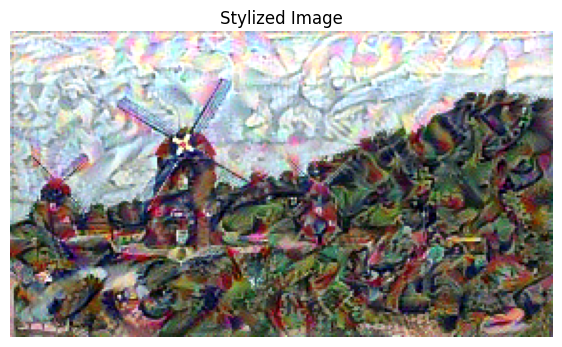

In [ ]:
# 스타일 전이 이미지 시각화
stylized_image = tf.squeeze(stylized_image.numpy(), axis=0)   # 배치 차원 축소
stylized_image = stylized_image[:, :, ::-1]   # BGR를 RGB로 변환
stylized_image += [124, 117, 104]   # ImageNet의 평균값 더하기
stylized_image = np.clip(stylized_image, 0, 255).astype("uint8")    # 0 ~ 255

plt.figure(figsize=(7, 7))

plt.imshow(stylized_image)
plt.title('Stylized Image')
plt.axis('off')

plt.show()

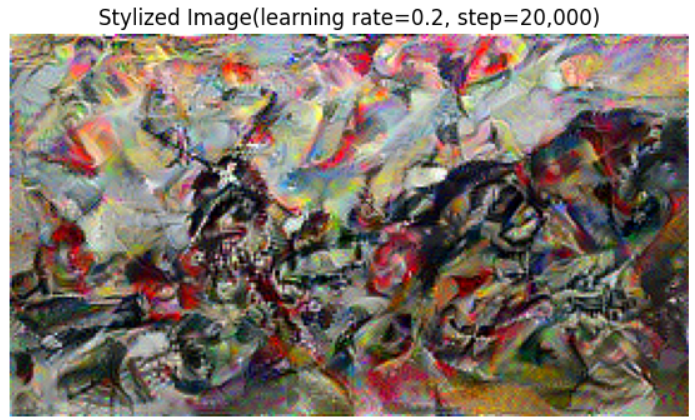

In [ ]:
# 스타일 전이 이미지 저장
tf.keras.utils.save_img('/content/drive/MyDrive/Colab Notebooks/'
   'stylized_image1.png', stylized_image)

In [ ]:
# 저장된 이미지 불러오기
file_path = '/content/drive/MyDrive/Colab Notebooks/stylized_image1.png'
stylized_image = Image.open(file_path)

In [ ]:
# 예제 8.5 스타일 전이(TensorFlowHUb)

# 셋업
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 콘텐츠 이미지(사진)/스타일 이미지(칸딘스키 구성8) 준비
content_path = '/content/drive/MyDrive/Datasets/충북대학교.jpg'
content_image = Image.open(content_path)

style_path = tf.keras.utils.get_file(   # Wikimedia Commons에서 다운로드
    'Composition8.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/'
    '0/02/Kandinsky_-_Composition_8%2C_1923.jpg')
style_image = Image.open(style_path)

218875/218875 [==============================] - 0s 0us/step


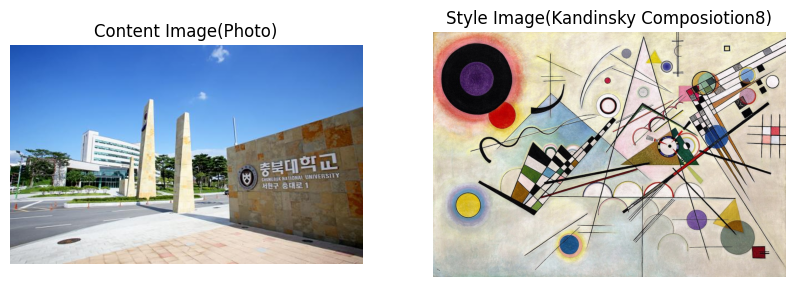

In [ ]:
# 콘텐츠 이미지/스타일 이미지 시각화
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title('Content Image(Photo)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title('Style Image(Kandinsky Composiotion8)')
plt.axis('off')

plt.show()

In [ ]:
# 스타일 이미지 크기 조정
width, height = content_image.size
style_image = tf.image.resize(style_image, (height, width))

# 이미지 배열로 변환하고 정규화
content_image = np.array(content_image, dtype=np.float32) / 255.
style_image = np.array(style_image, dtype=np.float32) / 255.

# 배치 차원 추가
content_image = np.expand_dims(content_image, axis=0)
style_image = np.expand_dims(style_image, axis=0)

print(f"shape of content image: {content_image.shape}")
print(f"shape of style image: {style_image.shape}")

shape of content image: (1, 398, 640, 3)
shape of style image: (1, 398, 640, 3)


In [ ]:
# 스타일 전이 모델 다운로드
url = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'

model = hub.load(url)

In [ ]:
# 스타일 전이 이미지 생성
outputs = model(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]   # 출력 리스트에서 첫 번째 텐서 선택
stylized_image = tf.squeeze(stylized_image, axis=0)   # 배치 차원 축소

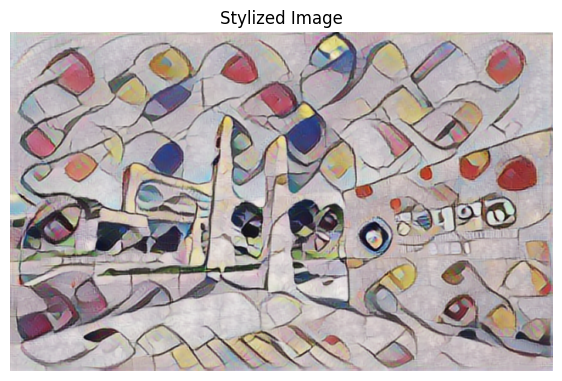

In [ ]:
# 스타일 전이 이미지 시각화
plt.figure(figsize=(7, 7))

plt.imshow(stylized_image)
plt.title('Stylized Image')
plt.axis('off')

plt.show()

In [ ]:
# 스타일 전이된 이미지 저장
stylized_image = stylized_image * 255   # 픽셀 값 스케일 조정(0 ~ 255)
stylized_image = np.array(stylized_image, dtype=np.uint8)   # 배열로 변환
stylized_image = Image.fromarray(stylized_image)   # PIL 이미지로 변환

file_path = '/content/drive/MyDrive/Colab Notebooks/stylized_image2.png'
stylized_image.save(file_path)

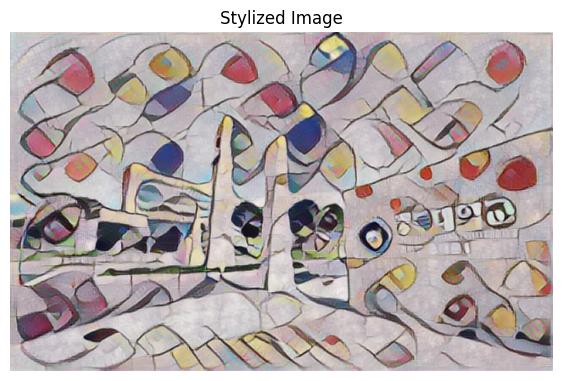

In [ ]:
# 저장된 이미지 불러오기
file_path = '/content/drive/MyDrive/Colab Notebooks/stylized_image2.png'
stylized_image = Image.open(file_path)

plt.figure(figsize=(7, 7))

plt.imshow(stylized_image)
plt.title('Stylized Image')
plt.axis('off')

plt.show()